In [21]:
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings("ignore")

# Kết nối đến database
connection_string = "mssql+pyodbc://LAPTOP-U1US2I6C/PortfolioProject?driver=ODBC+Driver+17+for+SQL+Server"
engine = create_engine(connection_string)


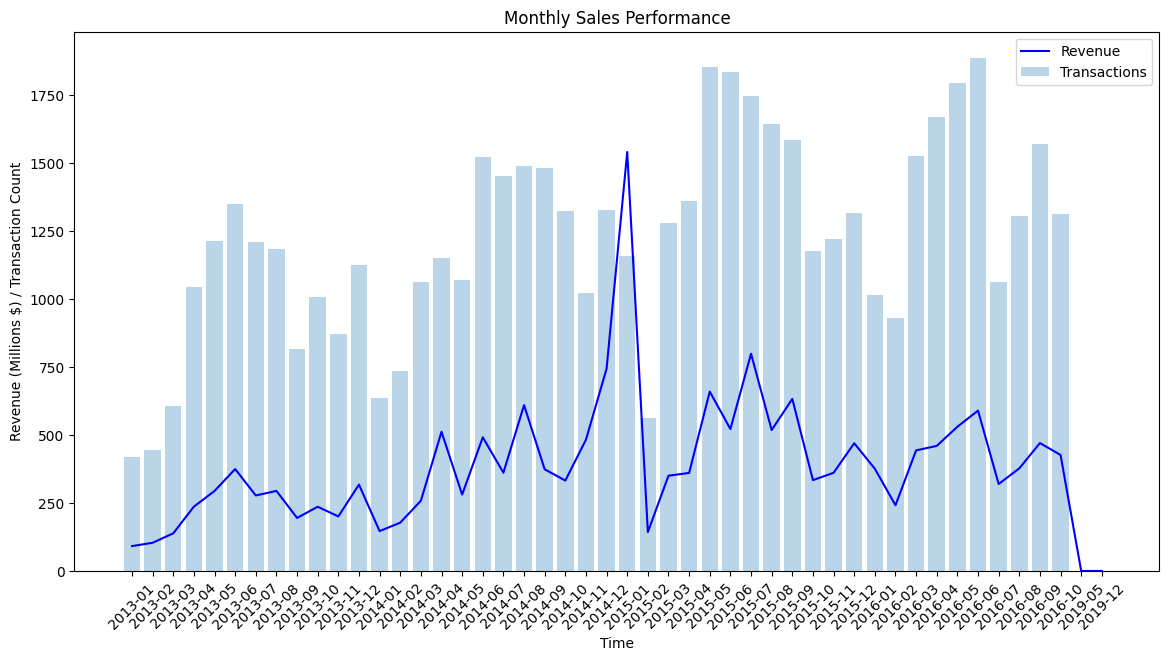

In [33]:
# Query 01: How have property transactions and revenue changed over time by month and year?
query1 = """
SELECT
    YEAR(SaleDate) AS Year,
    MONTH(SaleDate) AS Month,
    DATENAME(MONTH, SaleDate) AS MonthName,
    COUNT(*) AS TotalTransactions,
    SUM(SalePrice) AS TotalRevenue,
    AVG(SalePrice) AS AveragePrice
FROM PortfolioProject.dbo.[Nashville Housing]
WHERE SaleDate IS NOT NULL AND SalePrice > 0
GROUP BY YEAR(SaleDate), MONTH(SaleDate), DATENAME(MONTH, SaleDate)
ORDER BY Year, Month;
"""

df_sales = pd.read_sql(query1, conn)

plt.figure(figsize=(14, 7))
plt.plot(df_sales['Year'].astype(str) + '-' + df_sales['Month'].astype(str).str.zfill(2), 
         df_sales['TotalRevenue']/1e6, 'b-', label='Revenue')
plt.bar(range(len(df_sales)), df_sales['TotalTransactions'], alpha=0.3, label='Transactions')
plt.title('Monthly Sales Performance')
plt.xlabel('Time')
plt.ylabel('Revenue (Millions $) / Transaction Count')
plt.legend()
plt.xticks(rotation=45)
plt.show()

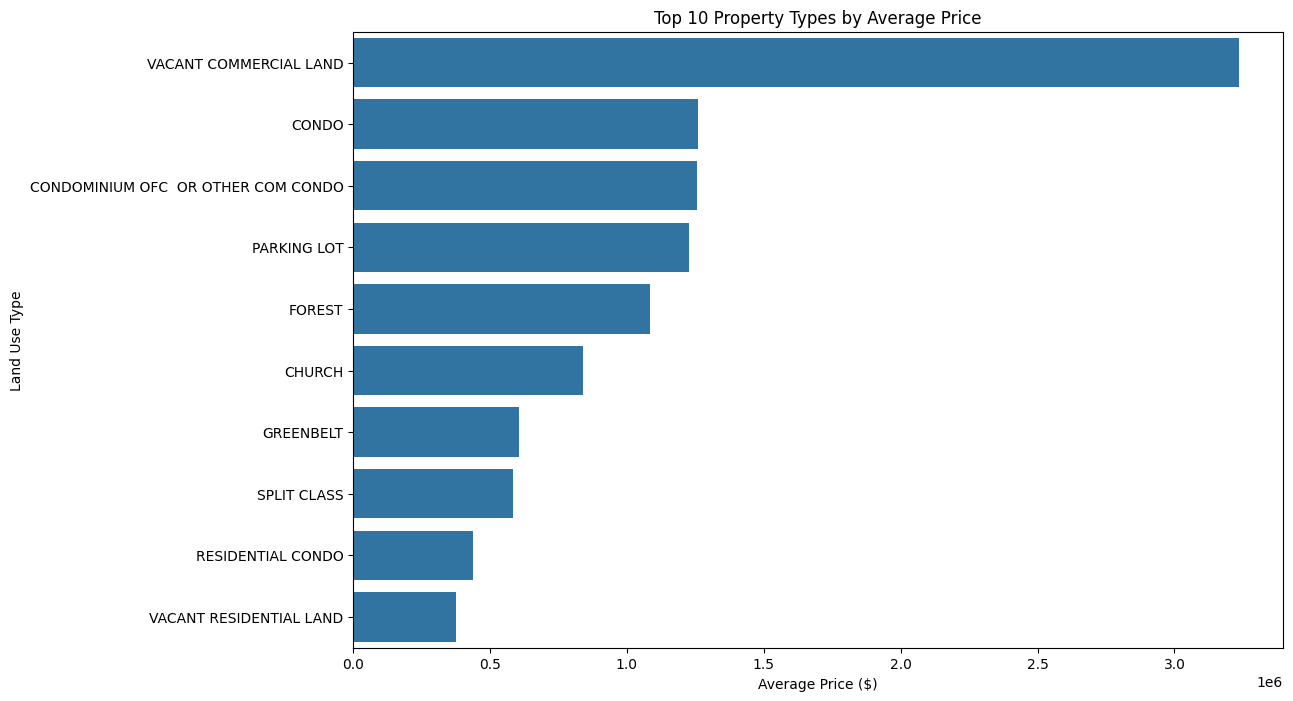

In [23]:
# Query 02: Which land use categories have the highest average property values?
query2 = """
SELECT
    LandUse,
    COUNT(*) AS PropertyCount,
    AVG(CONVERT(BIGINT, SalePrice)) AS AverageSalePrice,
    AVG(CONVERT(BIGINT, TotalValue)) AS AverageTotalValue,
    AVG(CONVERT(BIGINT, LandValue)) AS AverageLandValue,
    AVG(CONVERT(BIGINT, BuildingValue)) AS AverageBuildingValue,
    AVG(CONVERT(BIGINT, SalePrice)) - AVG(CONVERT(BIGINT, TotalValue)) AS ValueDifference
FROM PortfolioProject.dbo.[Nashville Housing]
WHERE LandUse IS NOT NULL AND SalePrice > 0
GROUP BY LandUse
HAVING COUNT(*) >= 10
ORDER BY AverageSalePrice DESC;
"""

df_property = pd.read_sql(query2, conn)

plt.figure(figsize=(12, 8))
sns.barplot(x='AverageSalePrice', y='LandUse', data=df_property.nlargest(10, 'AverageSalePrice'))
plt.title('Top 10 Property Types by Average Price')
plt.xlabel('Average Price ($)')
plt.ylabel('Land Use Type')
plt.show()

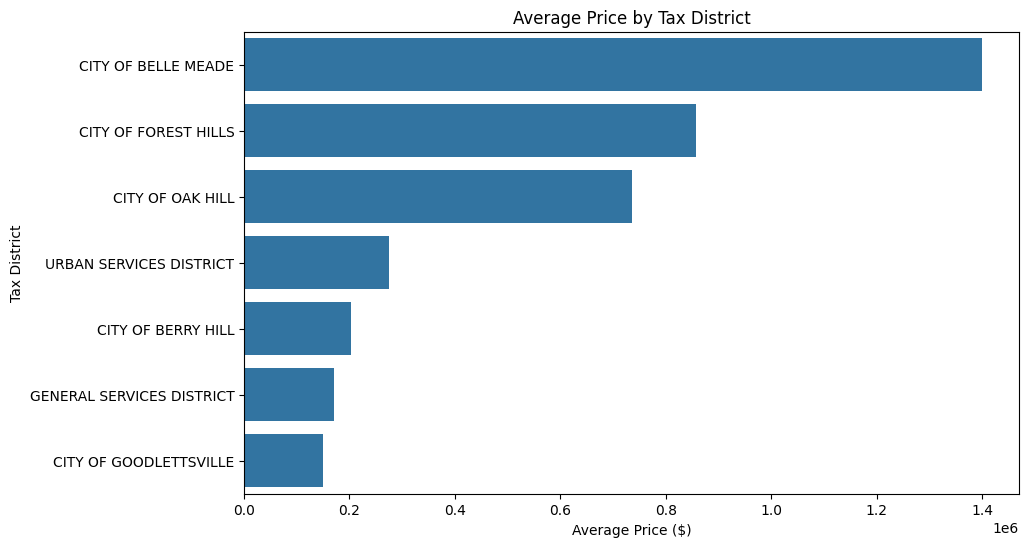

In [24]:
# Query 03: Do property values and price per acre vary significantly across tax districts?
query3 = """
SELECT
    TaxDistrict,
    COUNT(*) AS PropertyCount,
    AVG(SalePrice) AS AveragePrice,
    AVG(Acreage) AS AverageAcreage,
    AVG(SalePrice/NULLIF(Acreage, 0)) AS PricePerAcre,
    AVG(YearBuilt) AS AverageYearBuilt
FROM PortfolioProject.dbo.[Nashville Housing]
WHERE TaxDistrict IS NOT NULL AND Acreage > 0
GROUP BY TaxDistrict
HAVING COUNT(*) >= 5
ORDER BY AveragePrice DESC;
"""
df_geo = pd.read_sql(query3, conn)

plt.figure(figsize=(10, 6))
sns.barplot(x='AveragePrice', y='TaxDistrict', data=df_geo.sort_values('AveragePrice', ascending=False))
plt.title('Average Price by Tax District')
plt.xlabel('Average Price ($)')
plt.ylabel('Tax District')
plt.show()


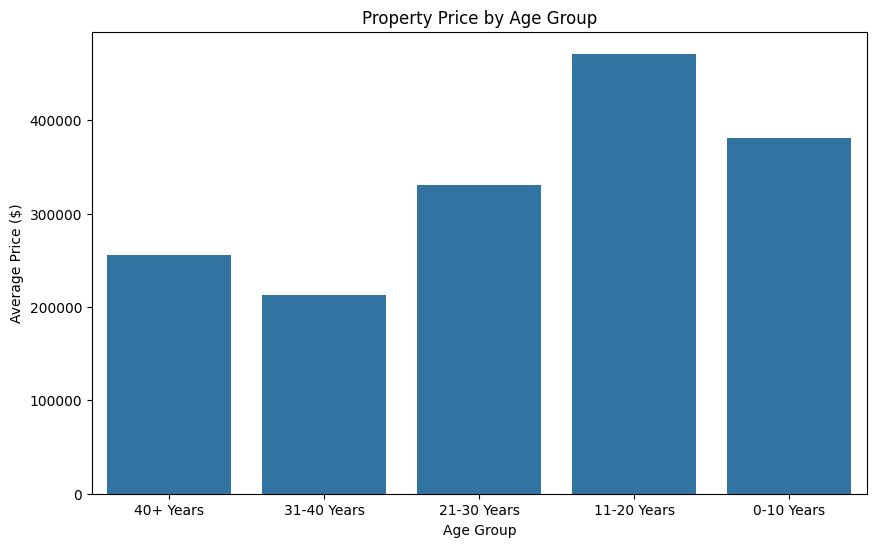

In [25]:
# Query 04: How does property age (newer vs older homes) affect average sale price and value?
query4 = """
SELECT
    CASE
        WHEN (YEAR(GETDATE()) - YearBuilt) <= 10 THEN '0-10 Years'
        WHEN (YEAR(GETDATE()) - YearBuilt) <= 20 THEN '11-20 Years'
        WHEN (YEAR(GETDATE()) - YearBuilt) <= 30 THEN '21-30 Years'
        WHEN (YEAR(GETDATE()) - YearBuilt) <= 40 THEN '31-40 Years'
        ELSE '40+ Years'
    END AS AgeGroup,
    COUNT(*) AS PropertyCount,
    AVG(CONVERT(BIGINT, SalePrice)) AS AveragePrice,
    AVG(CONVERT(BIGINT, TotalValue)) AS AverageValue,
    AVG(CONVERT(BIGINT, SalePrice)) - AVG(CONVERT(BIGINT, TotalValue)) AS AvgPriceValueDiff
FROM PortfolioProject.dbo.[Nashville Housing]
WHERE YearBuilt IS NOT NULL AND YearBuilt >= 1900
    AND SalePrice > 0 AND TotalValue > 0
GROUP BY CASE
    WHEN (YEAR(GETDATE()) - YearBuilt) <= 10 THEN '0-10 Years'
    WHEN (YEAR(GETDATE()) - YearBuilt) <= 20 THEN '11-20 Years'
    WHEN (YEAR(GETDATE()) - YearBuilt) <= 30 THEN '21-30 Years'
    WHEN (YEAR(GETDATE()) - YearBuilt) <= 40 THEN '31-40 Years'
    ELSE '40+ Years'
END
ORDER BY MIN(YearBuilt);
"""

df_age = pd.read_sql(query4, conn)

plt.figure(figsize=(10, 6))
sns.barplot(x='AgeGroup', y='AveragePrice', data=df_age)
plt.title('Property Price by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Price ($)')
plt.show()

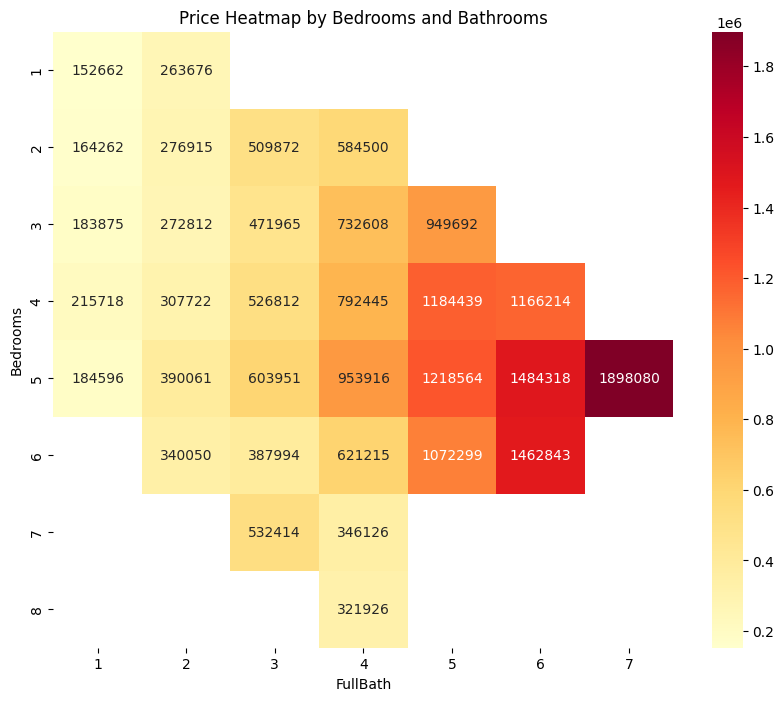

In [26]:
# Query 05: How do the number of bedrooms and bathrooms influence property prices?
query5 = """
SELECT
    Bedrooms,
    FullBath,
    HalfBath,
    COUNT(*) AS PropertyCount,
    AVG(CONVERT(BIGINT, SalePrice)) AS AveragePrice,
    AVG(SalePrice/NULLIF(Bedrooms, 0)) AS PricePerBedroom,
    AVG(SalePrice/NULLIF((FullBath + HalfBath*0.5), 0)) AS PricePerBathroom,
    AVG(TotalValue) AS AverageTotalValue
FROM PortfolioProject.dbo.[Nashville Housing]
WHERE Bedrooms > 0 AND FullBath > 0 AND SalePrice > 0
GROUP BY Bedrooms, FullBath, HalfBath
HAVING COUNT(*) >= 5
ORDER BY AveragePrice DESC;
"""
df_rooms = pd.read_sql(query5, conn)

# Tạo pivot table
pivot_table = df_rooms.pivot_table(values='AveragePrice', index='Bedrooms', columns='FullBath')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Price Heatmap by Bedrooms and Bathrooms')
plt.show()


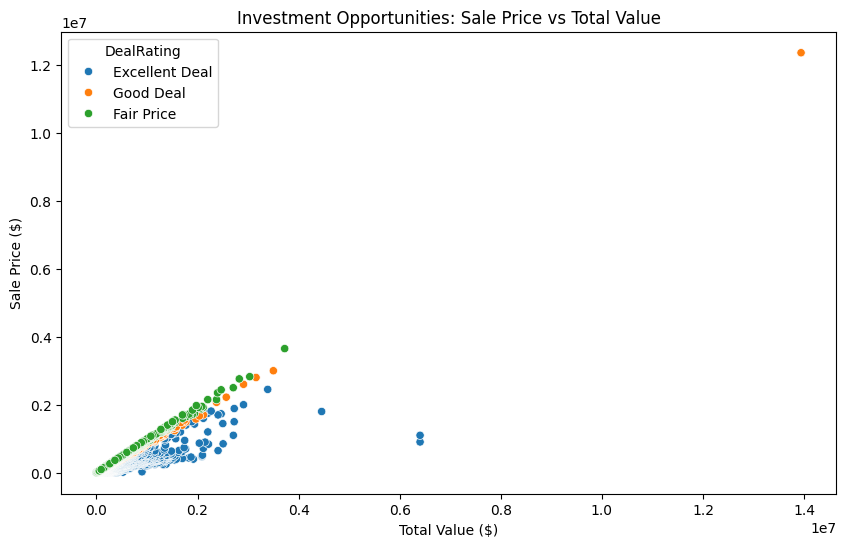

In [27]:
# Query 06: Which properties were sold below their estimated value, offering investment opportunities?
query6 = """
SELECT
    ParcelID,
    PropertySplitAddress,
    PropertySplitCity,
    LandUse,
    SalePrice,
    TotalValue,
    (SalePrice - TotalValue) AS ValueDifference,
    ROUND(((SalePrice - TotalValue)/NULLIF(TotalValue, 0)) * 100, 2) AS ReturnPercentage,
    CASE
        WHEN SalePrice <= TotalValue * 0.8 THEN 'Excellent Deal'
        WHEN SalePrice <= TotalValue * 0.9 THEN 'Good Deal'
        WHEN SalePrice <= TotalValue * 1.1 THEN 'Fair Price'
        ELSE 'Overpriced'
    END AS DealRating
FROM PortfolioProject.dbo.[Nashville Housing]
WHERE SalePrice > 0 
    AND TotalValue > 0
    AND (SalePrice - TotalValue) < 0 
ORDER BY ReturnPercentage ASC;
"""

df_invest = pd.read_sql(query6, conn)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalValue', y='SalePrice', hue='DealRating', data=df_invest)
plt.title('Investment Opportunities: Sale Price vs Total Value')
plt.xlabel('Total Value ($)')
plt.ylabel('Sale Price ($)')
plt.show()

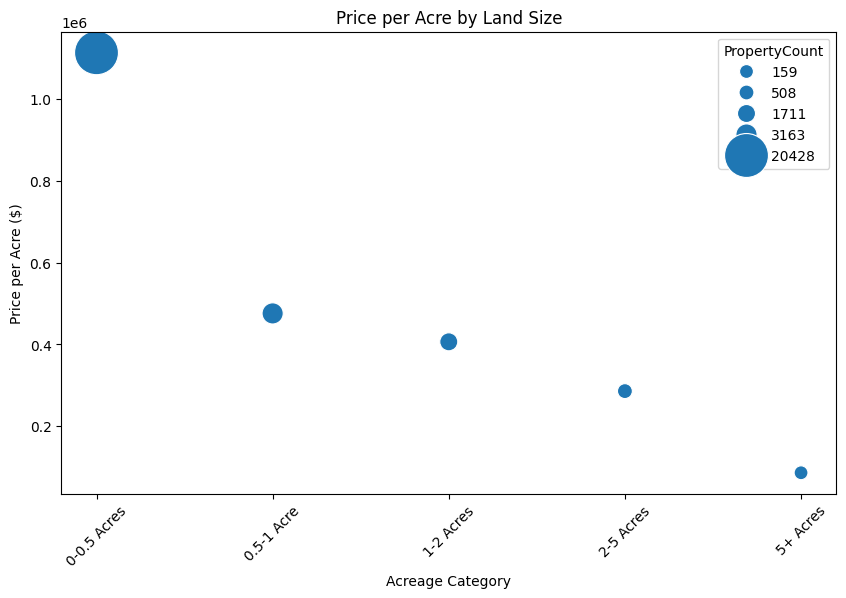

In [28]:
# Query 07: What is the price per acre across different land size categories?
query7 = """
SELECT
    CASE
        WHEN Acreage <= 0.5 THEN '0-0.5 Acres'
        WHEN Acreage <= 1 THEN '0.5-1 Acre'
        WHEN Acreage <= 2 THEN '1-2 Acres'
        WHEN Acreage <= 5 THEN '2-5 Acres'
        ELSE '5+ Acres'
    END AS AcreageCategory,
    COUNT(*) AS PropertyCount,
    AVG(CONVERT(BIGINT, SalePrice)) AS AveragePrice,
    AVG(Acreage) AS AverageAcreage,
    AVG(SalePrice/NULLIF(Acreage, 0)) AS PricePerAcre,
    AVG(LandValue/NULLIF(Acreage, 0)) AS LandValuePerAcre
FROM PortfolioProject.dbo.[Nashville Housing]
WHERE Acreage > 0 AND SalePrice > 0
GROUP BY CASE
    WHEN Acreage <= 0.5 THEN '0-0.5 Acres'
    WHEN Acreage <= 1 THEN '0.5-1 Acre'
    WHEN Acreage <= 2 THEN '1-2 Acres'
    WHEN Acreage <= 5 THEN '2-5 Acres'
    ELSE '5+ Acres'
END
ORDER BY PricePerAcre DESC;
"""

df_land = pd.read_sql(query7, conn)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='AcreageCategory', y='PricePerAcre', size='PropertyCount', 
                sizes=(100, 1000), data=df_land)
plt.title('Price per Acre by Land Size')
plt.xlabel('Acreage Category')
plt.ylabel('Price per Acre ($)')
plt.xticks(rotation=45)
plt.show()

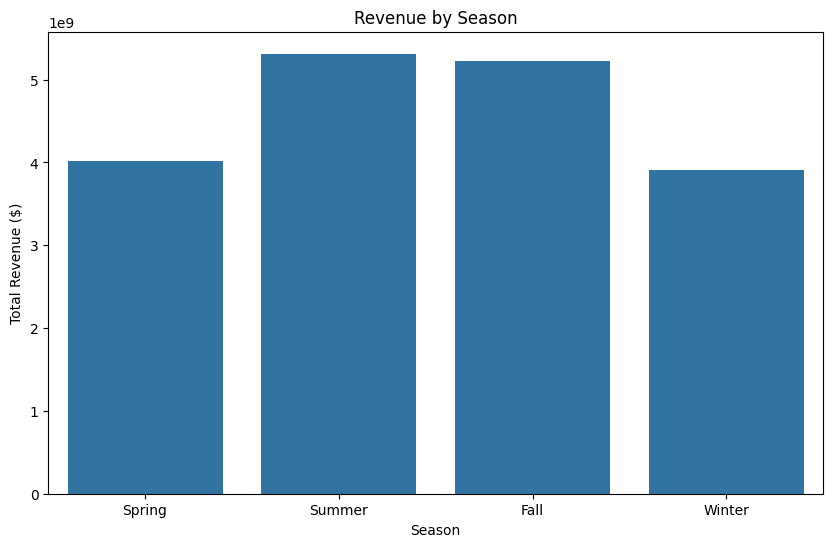

In [29]:
# Query 08: Do real estate sales follow seasonal trends (Spring, Summer, Fall, Winter)?
query8 = """
SELECT
    DATEPART(QUARTER, SaleDate) AS Quarter,
    CASE DATEPART(QUARTER, SaleDate)
        WHEN 1 THEN 'Spring'
        WHEN 2 THEN 'Summer'
        WHEN 3 THEN 'Fall'
        WHEN 4 THEN 'Winter'
    END AS Season,
    COUNT(*) AS TotalSales,
    SUM(SalePrice) AS TotalRevenue,
    AVG(SalePrice) AS AveragePrice,
    MIN(SaleDate) AS FirstSaleDate,
    MAX(SaleDate) AS LastSaleDate
FROM PortfolioProject.dbo.[Nashville Housing]
WHERE SaleDate IS NOT NULL AND SalePrice > 0
GROUP BY DATEPART(QUARTER, SaleDate)
ORDER BY Quarter;
"""

df_season = pd.read_sql(query8, conn)

plt.figure(figsize=(10, 6))
sns.barplot(x='Season', y='TotalRevenue', data=df_season)
plt.title('Revenue by Season')
plt.xlabel('Season')
plt.ylabel('Total Revenue ($)')
plt.show()